In [47]:
!pip install tensorflow-model-optimization

  Using cached tensorflow_model_optimization-0.8.0-py2.py3-none-any.whl (242 kB)
  Using cached dm_tree-0.1.9-cp310-cp310-win_amd64.whl (101 kB)
  Using cached absl_py-1.4.0-py3-none-any.whl (126 kB)
  Attempting uninstall: absl-py
    Found existing installation: absl-py 2.1.0
    Uninstalling absl-py-2.1.0:
      Successfully uninstalled absl-py-2.1.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.10.0 requires tensorflow<2.11,>=2.10.0; platform_machine != "arm64" or platform_system != "Darwin", but you have tensorflow 2.19.0 which is incompatible.

[notice] A new release of pip available: 22.2.2 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### **Import all the dependencies**

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers 
import matplotlib.pyplot as plt
import numpy as np

ModuleNotFoundError: No module named 'tensorflow_model_optimization'

### **Create a dataset**

Define some parameters for loading:

In [2]:
BATCH_SIZE = 32
IMG_HEIGHT = 256
IMG_WIDTH = 256
EPOCHS = 50
CHANNELS = 3

Import data into tensorflow dataset object

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'PlantVillage',
    shuffle = True,
    image_size= (IMG_HEIGHT, IMG_WIDTH),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
dataset.class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
len(dataset)

68

### **Visualize the data**

Here are some the first 9 images from the dataset:

In [7]:
for image, label in dataset.take(1):
    print(image.shape)
    print(label.numpy)

(32, 256, 256, 3)
<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 1], dtype=int32)>>


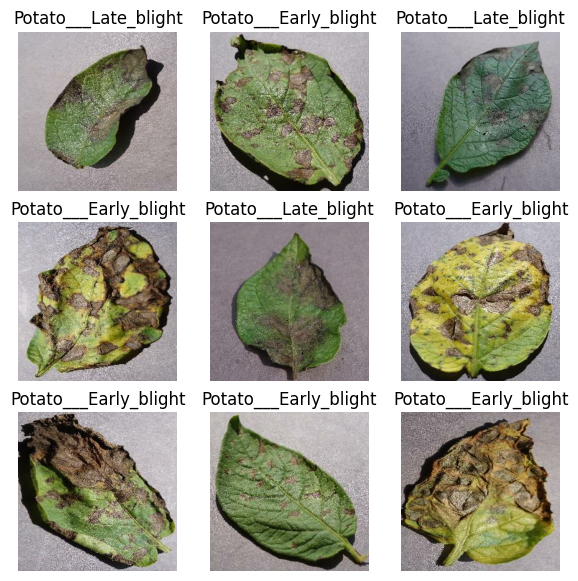

In [8]:
plt.figure(figsize= (7, 7))
for image_batch, label_batch in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [9]:
# 80% => training
# 10% => validation, 10% => test

### **Split the dataset**

Dataset should be splitted into 3 subset, namely:
- Training: Use while training step
- Validation: Check again while training step
- Test: Check agian after completely building the model

In [10]:
# Function to split the data
def split_the_data(dataset, train_split= 0.8, valid_split= 0.1, test_split= 0.1, shuffle= True, shuffle_size= 1000):
    
    ds_size = len(dataset)
    
    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed= 42)
         
    train_size = int(train_split * ds_size)
    valid_size = int(valid_split * ds_size)
    
    train_data = dataset.take(train_size)
    valid_data = dataset.skip(train_size).take(valid_size)
    test_data = dataset.skip(train_size).skip(valid_size)
    
    return train_data, valid_data, test_data

In [11]:
train_data, valid_data, test_data = split_the_data(dataset)

In [12]:
print("The length of training data:", len(train_data))
print("The length of validation data:", len(valid_data))
print("The length of test data:", len(test_data))

The length of training data: 54
The length of validation data: 6
The length of test data: 8


Cache, Shuffle, and Prefetch the dataset

In [13]:
train_data = train_data.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)
valid_data = valid_data.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)
test_data = test_data.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)

### **Image Processing**

Before we feed images to network, , we should resize them to the desired size. Moreover, to improve the model performance, we should normalize the image pixel value in range [0, 1].

In [14]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMG_HEIGHT, IMG_WIDTH),
    layers.Rescaling(1./ 255)
])

Because the data is quite less, so we should use Data Augmentation. This method will help the model learn more features and boost the accuracy of our model.

In [15]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

### **Model Building**

##### Build layers for the model

In [16]:
input_shape = (BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, CHANNELS)
n_classes = len(np.unique(class_names))

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size= (3, 3), activation= 'relu', input_shape= input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size= (3,3), activation= 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size= (3,3), activation= 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size= (3,3), activation= 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size= (3,3), activation= 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size= (3,3), activation= 'relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(64, activation= 'relu'),
    layers.Dense(n_classes, activation= 'softmax')
])

model.build(input_shape= input_shape)

d:\Python 3.10.8\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

##### Compile the model

In [18]:
model.compile(
    optimizer= 'adam',
    loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits= False),
    metrics= ['accuracy']
)

In [19]:
history = model.fit(
    train_data,
    batch_size= BATCH_SIZE,
    validation_data= valid_data,
    verbose= 1, # hiển thị progress bar để theo dõi
    epochs= 50
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.4837 - loss: 0.9395 - val_accuracy: 0.6146 - val_loss: 0.8547
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.6434 - loss: 0.7607 - val_accuracy: 0.7656 - val_loss: 0.5408
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 54s 995ms/step - accuracy: 0.8136 - loss: 0.4766 - val_accuracy: 0.7552 - val_loss: 0.6650
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.8966 - loss: 0.2869 - val_accuracy: 0.9010 - val_loss: 0.2391
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 48s 884ms/step - accuracy: 0.9050 - loss: 0.2871 - val_accuracy: 0.8594 - val_loss: 0.3754
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 47s 864ms/step - accuracy: 0.9220 - loss: 0.1969 - val_accuracy: 0.9583 - val_loss: 0.1498
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 46s 859ms/step - accuracy: 0.9539 - loss: 0.1059 - val_accuracy: 0.8438 - val_loss: 0.4070
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 49s 900ms/step - accuracy: 0.9708 - loss: 0.0875 - val_accuracy: 0.8

In [20]:
scores = model.evaluate(test_data)  
scores

8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 531ms/step - accuracy: 0.9678 - loss: 0.0423


[0.04002455249428749, 0.97265625]

**You can see the accuracy get 96% on the testing data. This means that the model is pretty goood.**

##### Plotting the Accuracy and Loss

In [21]:
history

In [22]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [23]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [24]:
# Take the accuracy and value_accuracy of the training model
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Take the loss and value_losss of the training model
loss = history.history['loss']
val_loss = history.history['val_loss']

In [25]:
range(EPOCHS)

range(0, 50)

Text(0.5, 1.0, 'Training and Validation Loss')

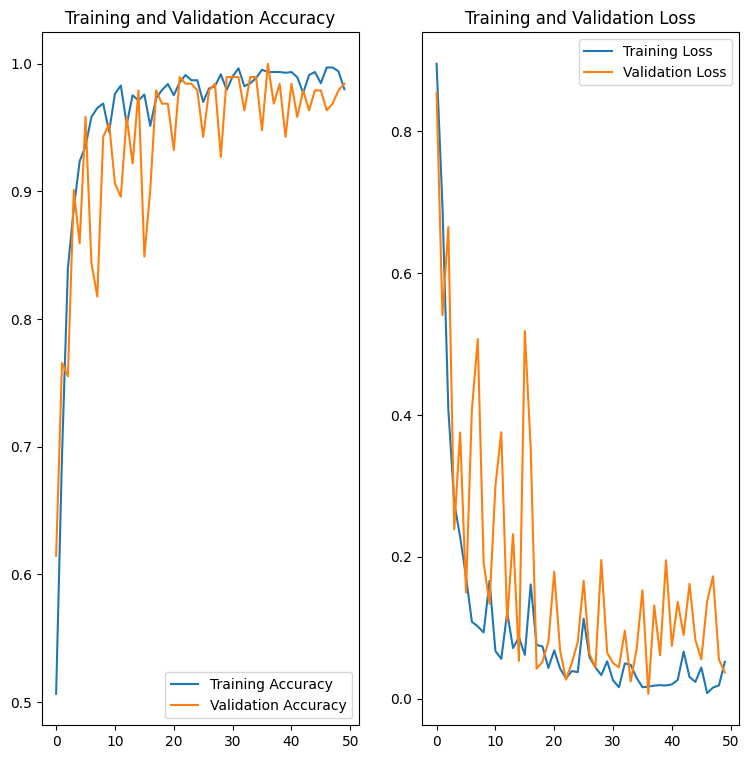

In [26]:
plt.figure(figsize= (9, 9))

plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label= 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label= 'Validation Accuracy')
plt.legend(loc= 'lower right')
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label= 'Training Loss')
plt.plot(range(EPOCHS), val_loss, label= 'Validation Loss')
plt.legend(loc= 'upper right')
plt.title("Training and Validation Loss")

##### Prediction on sample image

First image to predict:
Actual prediction: Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[1.0000000e+00 2.8677234e-11 1.3038769e-24]
Predicted label: Potato___Early_blight


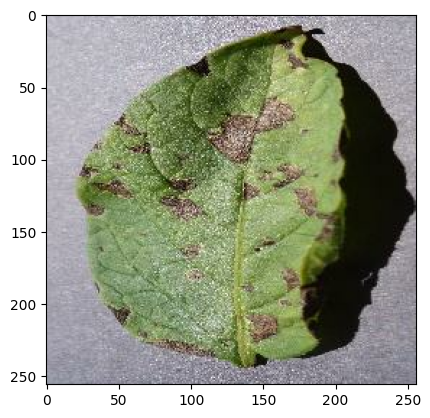

In [27]:
for image, label in test_data.take(1):
    
    first_img = image[0].numpy().astype("uint8")
    first_label = label[0]
    
    print("First image to predict:")
    plt.imshow(first_img)
    print("Actual prediction:", class_names[first_label])
    
    model_prediciton = model.predict(image)
    print(model_prediciton[0])
    print("Predicted label:", class_names[np.argmax(model_prediciton[0])])

In [28]:
# def predict(model, img):
#     img_array = tf.keras.preprocessing.image.img_to_array(image[i].numpy())
#     img_array = tf.expand_dims(img_array, 0)
    
#     prediction = model.predict(img_array)
    
#     predicted_class = class_names[np.argmax(prediction[0])]
#     confidence = round(100 * np.max(prediction[0]), 2)
#     return predicted_class, confidence

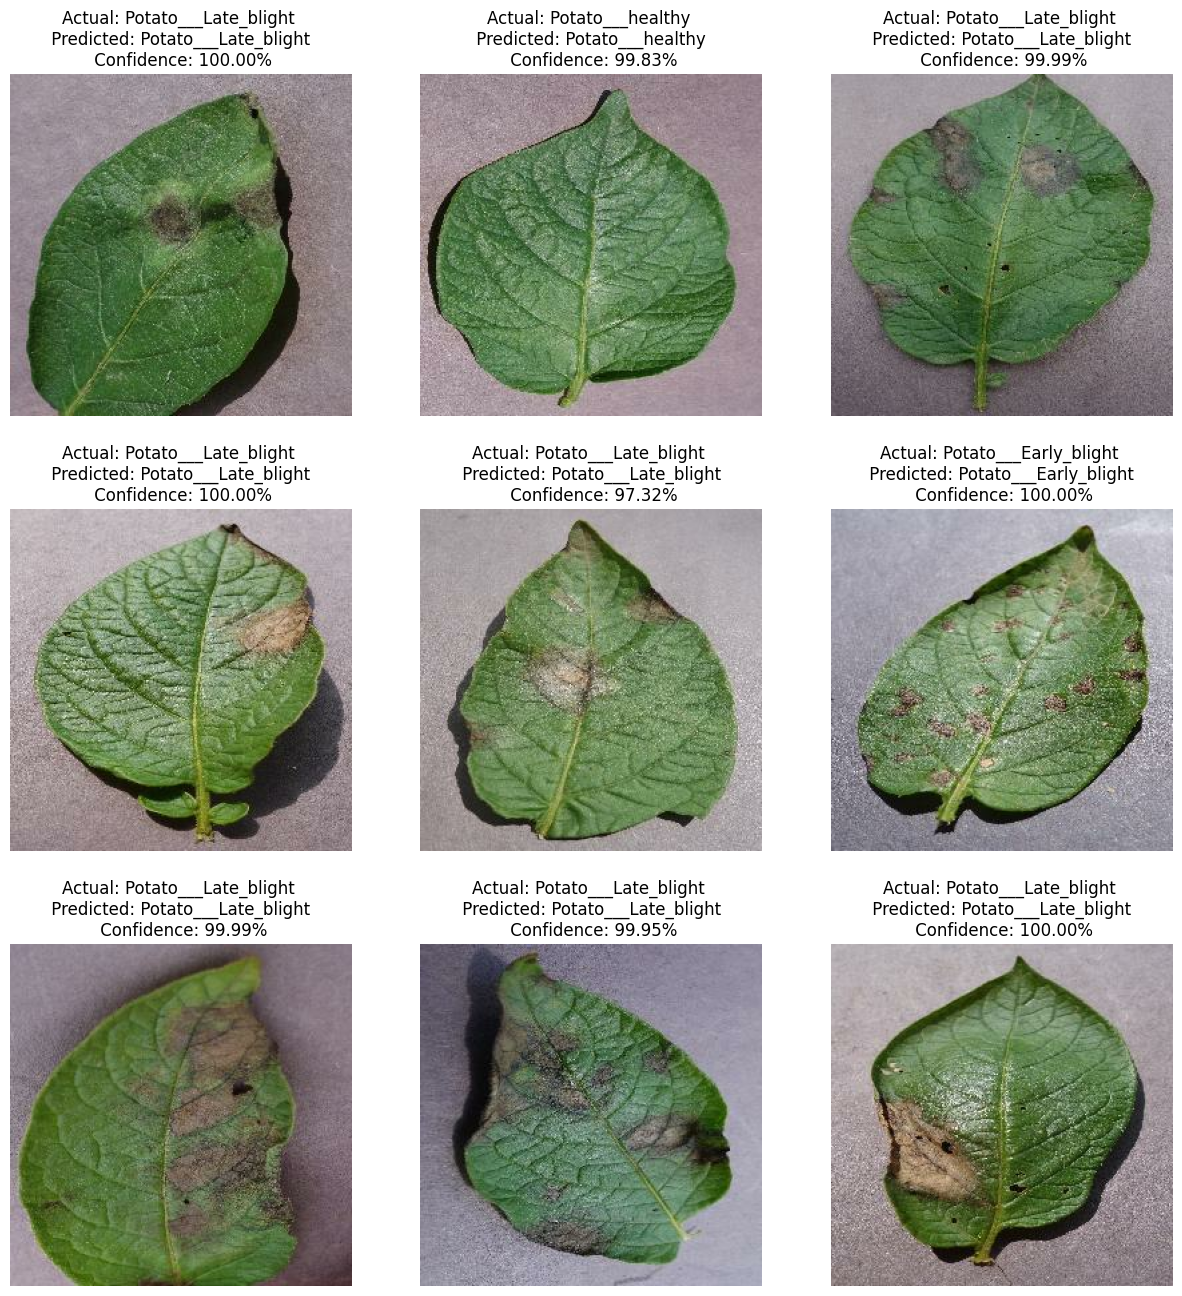

In [29]:
plt.figure(figsize= (15, 16))

for image_batch, label_batch in test_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        img = image_batch[i].numpy()
        plt.imshow(img.astype("uint8"))
        
        # Predict the image
        img_array = tf.expand_dims(img, 0) # Add batch dimension to shape (1, h, w, channels)
        prediction = model.predict(img_array, verbose= 0)
        predicted_label = class_names[np.argmax(prediction[0])]
        confidence = np.max(prediction[0]) * 100
                        
        plt.title(f"Actual: {class_names[label_batch[i]]} \n Predicted: {predicted_label} \n Confidence: {confidence:.2f}%")
        plt.axis("off")

### **Saving the Model**

In [ ]:
model.save("../potatoes.h5")

In [41]:
# import os
# model_version = max([int(i) for i in os.listdir("../saved_models") + [0]]) + 1
# model.export(f"../saved_models/{model_version}")